## Load Lung CT Scan and Displays nodules (Dicom files from LUNA16 challenge publicly available at LIDC/IDRI database used). 
The LUNA16 challenge (http://luna16.grand-challenge.org/home/) will focus on automatic nodule detection on the LIDC/IDRI data set. The LIDC/IDRI data set includes the annotations of nodules by four radiologists.

In [1]:
import SimpleITK as sitk
import numpy as np
import csv
import pandas as pd
from ipywidgets import interact
import matplotlib.pyplot as plt
from PIL import Image
import os
from matplotlib.patches import Circle
from matplotlib.pylab import subplots
import matplotlib.patches as patches 
%matplotlib inline

## SimpleITK

#### Loading the native DICOM files produced by the CT scanner as an Image. However, it is often more convienent to save the entire 3D volume to a MHD format. The files can be in raw or series format.
#### LUNA16 data set from NCI is used and for illustration purpose, loading one DICOM file, the annotations i.e. Regions of Interest are marked in annotation file.

In [2]:
data_dir = '../data/Lung/'
img_filename = '1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437.mhd'
annotations_file = 'annotations.csv'
itk_img = sitk.ReadImage(data_dir + img_filename)  # Dimensions are ordered as X, Y, Z (height, width, depth)

In [3]:
print('The pixel dimensions are {} mm'.format(itk_img.GetSpacing()))
print('There are {} slices in the CT volume.'.format(itk_img.GetDepth()))
print('So the depth is {} mm (i.e. total slice * 2.5)'.format(itk_img.GetDepth()*itk_img.GetSpacing()[2]))
print('That should be about the distance from the neck to the navel.')
print('Slice  #1 is closer to the feet. Slice #{} is closer to the head'.format(itk_img.GetDepth()))

The pixel dimensions are (0.78125, 0.78125, 2.5) mm
There are 117 slices in the CT volume.
So the depth is 292.5 mm (i.e. total slice * 2.5)
That should be about the distance from the neck to the navel.
Slice  #1 is closer to the feet. Slice #117 is closer to the head


#### Converting Image to numpy 3D matrix. The SimpleITK function GetArrayFromImage converts DICOM image to 3D matrix. The values in 3D matrix are the Hounsfield Units (HU) or CT number describing the radiodensity of the substance. 
##### Some of the Hounsfield Unit for substance 
| Substance | HU | Notes         
| :- |-------------: | :-:
|Air| -1000  | 
|Fat| -120 to -90 | 
|Water| 0 | 
|Soft Tissue, Contrast| 100 to 300  | 
|Lung| -700 to -600  | 
|Lymph nodes| 10 to 20  | 
|Blood| 13 to 50  | 
|Muscle| 35 to 55  | 
######  The X, Y, Z axis of loaded image represent Inferior, Superior and Traverse plane . SimpleITK stores the Image information as x,y,z (height, width, depth). When it converts it to numpy, the array is now z,y,x (depth, width, height).

In [4]:
# SimpleITK keeps the origin and spacing information for the 3D image volume
img_np_array = sitk.GetArrayFromImage(itk_img) # indices are z,y,x (note the ordering of dimensions)

##### When this becomes a numpy array we now have 117 slices of 512 x 512 (Height x Width)

In [5]:
img_np_array.shape

(117, 512, 512)

In [6]:
## Uncomment the following lines to view the Images as is (without normalization)
# def displaySlice(sliceNo):
#     plt.figure(figsize=[10,10]);
#     plt.title('Slice #{}'.format(sliceNo));
#     plt.imshow(img_np_array[sliceNo-1,:,:], cmap='bone'); 
#     plt.show()
    
# print('Move the slider to go through the slices.')
# interact(displaySlice, sliceNo=(1,img_np_array.shape[0],1));

### Normalizing the image to sets the Voxel size to 1x1x1 mm (as the spacing in Inferrior, Superior, Traverse i.e. x,y,z is of different size)

In [7]:
pixel_spacing = [1.0, 1.0, 1.0] # New Voxel spacing in mm (feel free to change this)

def normalize_img(img):
    
    new_x_size = img.GetSpacing()[0]*img.GetWidth()  # Number of Voxels you want for x dimension
    new_y_size = img.GetSpacing()[1]*img.GetHeight() # Number of Voxels you want for y dimension
    new_z_size = img.GetSpacing()[2]*img.GetDepth()  # Number of Voxels you want for z dimesion
    new_size = [new_x_size, new_y_size, new_z_size]

    new_spacing = pixel_spacing  # mm per voxel (x,y,z) (h, w, d)

    new_size = np.rint(np.array(new_size) / np.array(new_spacing)).astype(int)

    #interpolator_type = sitk.sitkLinear
    interpolator_type = sitk.sitkBSpline

    img_norm = sitk.Resample(img, np.array(new_size, dtype='uint32').tolist(), sitk.Transform(), interpolator_type, img.GetOrigin(),\
                             new_spacing, img.GetDirection(), 0.0, img.GetPixelIDValue())   
    # For some reason I need to correct the origin to the new scaling factor
    img_norm.SetOrigin(np.array(img.GetOrigin()) / np.array(new_spacing))

    return img_norm
itk_img_norm = normalize_img(itk_img)

#### Converting Normalized Image to numpy 3D array. The values are in HU descrbing the radiodensity 

In [8]:
img_np_array_norm = sitk.GetArrayFromImage(itk_img_norm)

In [9]:
print('After resizing the voxels to 1x1x1 mm each the matrix dimensions are now: {}'.format(img_np_array_norm.shape))
print('But the depth is still {} mm'.format(itk_img_norm.GetDepth()*itk_img_norm.GetSpacing()[2]))
print('That should be about the distance from the neck to the navel.')

After resizing the voxels to 1x1x1 mm each the matrix dimensions are now: (292, 400, 400)
But the depth is still 292.0 mm
That should be about the distance from the neck to the navel.


In [10]:
def displaySliceNorm(sliceNo):
    plt.figure(figsize=[10,10]);
    plt.title('Slice #{}'.format(sliceNo));
    plt.imshow(img_np_array_norm[sliceNo-1,:,:], cmap='bone'); 
    plt.show()
    
print('Move the slider to go through the slices.')
interact(displaySliceNorm, sliceNo=(1,img_np_array_norm.shape[0],1));

Move the slider to go through the slices.


#### Uncomment the following cell code to view the image along Y (Coronal) axis 

In [11]:
# def displaySliceCoronal(sliceNo):
#     plt.figure(figsize=[10,10]);
#     plt.title('Slice #{}'.format(sliceNo));
#     plt.imshow(img_np_array_norm[::-1,sliceNo-1,:], cmap='bone'); 
# #     plt.imshow(img_np_array_norm[::-1, :, sliceNo-1], cmap='bone');  #USe this line for X (Saggital) axis

#     plt.show()    
# print('Move the slider to go through the slices.')
# interact(displaySliceCoronal, sliceNo=(1,img_np_array_norm.shape[1],1));

#### Reading the annotation file for marked nodules (Region of Interest, ROI) in x,y, z coordinates storing it in a list. Note the coordinates are given in world coordinates (which will changed to Voxel coordinates later, as we have normalized the images).

In [12]:
cands_df = pd.read_csv(data_dir + annotations_file, header=None)
print ('Total number of marked nodule coordinates are {} '.format(len(cands_df)) )
# cands_df

Total number of marked nodule coordinates are 9 


##### Extracting the Origin and Pixel spacing from the original image

In [14]:
numpyOrigin = np.array(list(reversed(itk_img.GetOrigin())))
numpySpacing = np.array(list(reversed(itk_img.GetSpacing())))

print ("Image Origin in Z, Y, X order : {}".format(numpyOrigin))
print ("Image Spacing in Z, Y, X order : {}".format(numpySpacing))

numpySpacing_Normalized = np.array([1.0, 1.0, 1.0])
print ("Image Normalized Spacing in Z, Y, X order : {}".format(numpySpacing_Normalized))

Image Origin in Z, Y, X order : [-311.25 -200.   -207.5 ]
Image Spacing in Z, Y, X order : [2.5     0.78125 0.78125]
Image Normalized Spacing in Z, Y, X order : [1. 1. 1.]


### Procedure for changing the world coordinates to Voxel coordinates
Since the coordinates of nodules are given in World Coordinates, we transform from world coordinates to voxel coordinates. 
As their is no rotation component in LUNA16 data set so we can use the following simple formula for conversion. 


In [15]:
def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = np.array(stretchedVoxelCoord / spacing).astype(int)
    return voxelCoord

### Reading the annotation list, converting each element from World to Voxel coordinate, which represents the core/center of a nodule. Then showing only the slices having nodules.

Voxel coord in Z, Y, X (with normalized spacing): [220 250 141]


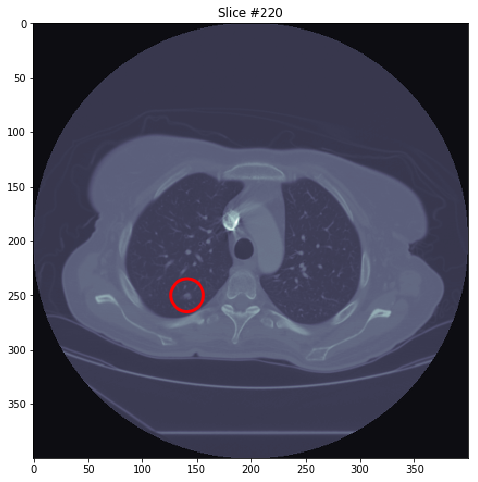

Voxel coord in Z, Y, X (with normalized spacing): [206 182 101]


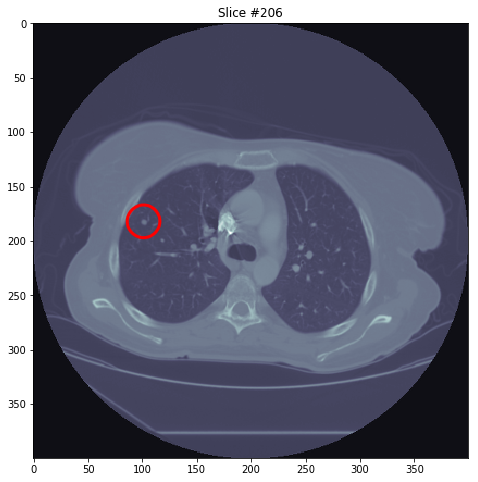

Voxel coord in Z, Y, X (with normalized spacing): [226 256 249]


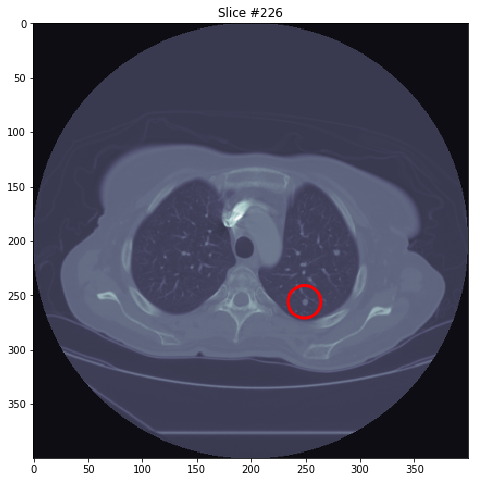

Voxel coord in Z, Y, X (with normalized spacing): [159 178  69]


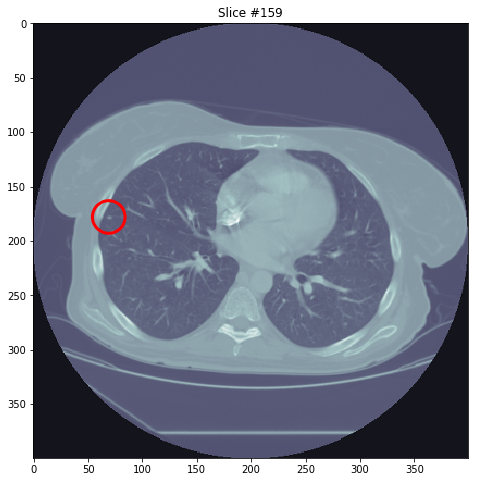

Voxel coord in Z, Y, X (with normalized spacing): [143 238 180]


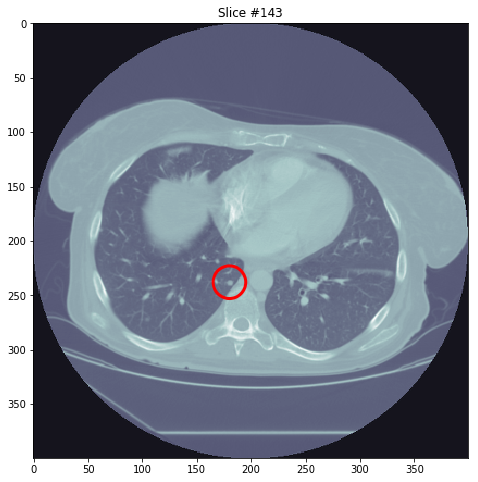

Voxel coord in Z, Y, X (with normalized spacing): [225 210 278]


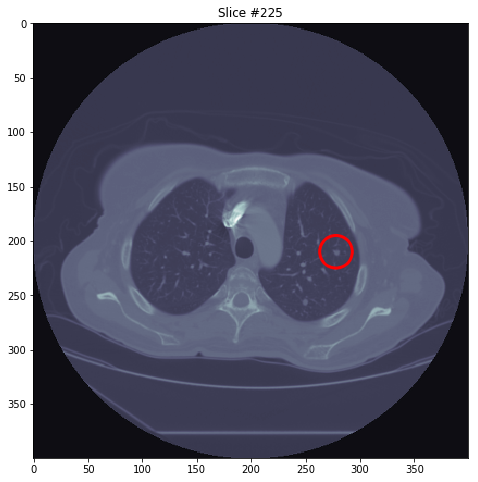

Voxel coord in Z, Y, X (with normalized spacing): [215 241 267]


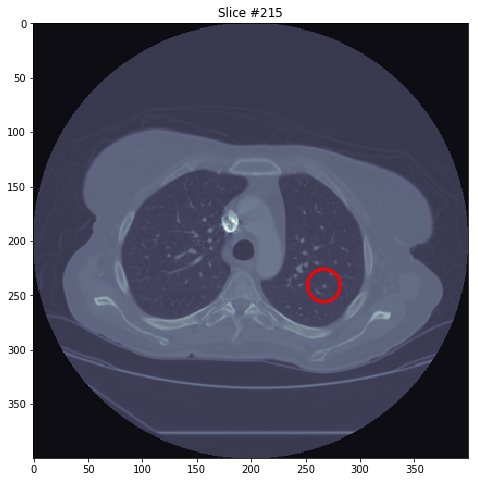

Voxel coord in Z, Y, X (with normalized spacing): [172 223 306]


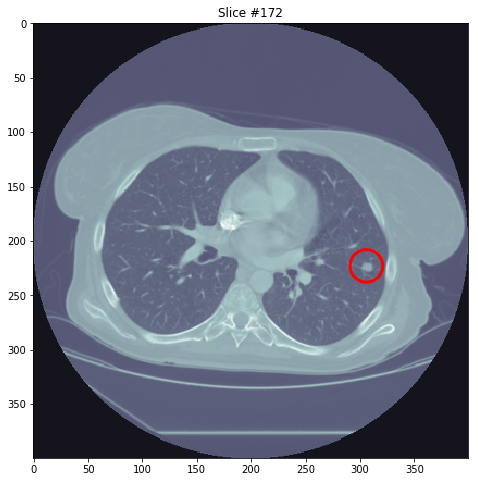

Total number of Nodules are 8
Nodules found on Slice numbers [143, 159, 172, 206, 215, 220, 225, 226]


In [16]:
nodule_slices_lst = []
cands = cands_df.values.tolist()

for cand in cands[1:]:
    worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
    voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing_Normalized)
    nodule_slices_lst.append(voxelCoord[0])

    fig,ax = plt.subplots(figsize=(8,8))
    print ('Voxel coord in Z, Y, X (with normalized spacing): {}'.format(voxelCoord));
#    print ('Value at Voxel coord is : {}'.format(img_np_array_norm[voxelCoord[0],voxelCoord[1], voxelCoord[2]] ));

    plt.imshow(img_np_array_norm[voxelCoord[0],:,:], cmap='bone');    

    circ = Circle((voxelCoord[2],voxelCoord[1]),15, lw=3.,fill=False, edgecolor='r') 
    ax.add_patch(circ)

    plt.title('Slice #{}'.format(voxelCoord[0]));
    plt.show() 
    
print ('Total number of Nodules are {}'.format(len (nodule_slices_lst) ));    
print ('Nodules found on Slice numbers {}'.format(sorted (nodule_slices_lst) ));

In [17]:
### Uncomment the following to slide and view all the slices marked with center of a nodule. 
# def test(sliceNo):
#     fig,ax = plt.subplots(figsize=(10,10))
        
#     for cand in cands[1:9]:
#         worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
#         voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing_Normalized)
        
#         circ = Circle((voxelCoord[2],voxelCoord[1]),15, lw=3.,fill=False, edgecolor='r') 
#         if (sliceNo == voxelCoord[0]):
#             ax.add_patch(circ)
        
#     plt.imshow(img_np_array_norm[sliceNo-1,:,:], cmap='bone');    
    
#     plt.title('Slice #{}'.format(sliceNo));
#     plt.show()    
    
# print('Move the slider to go through the slices.')
# interact(test, sliceNo=(1,img_np_array_norm.shape[0],1));

#### Following slider also shows the adjescent slices to the center of a specific nodule. As an example on slice 172, last annotation coordinate is marked and shown.
Notice the appearance and disappearance of nodule from slice 169 to 178 (move the slider to move between slices) 

In [18]:
def test(sliceNo):
    fig,ax = plt.subplots(figsize=(8,8))
        
    plt.imshow(img_np_array_norm[sliceNo-1,:,:], cmap='bone');    
    worldCoord = np.asarray([float(cands[8][3]),float(cands[8][2]),float(cands[8][1])])
    voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing_Normalized)
    
    circ = Circle((voxelCoord[2],voxelCoord[1]),15, lw=3.,fill=False, edgecolor='r') 
    ax.add_patch(circ)

    plt.title('Slice #{}'.format(sliceNo));
    plt.show()    
    
print('Move the slider to go through the slices.')
interact(test, sliceNo=(1,img_np_array_norm.shape[0],1));

Move the slider to go through the slices.


### Segment/patch around the nodule (Voxel coordinates)
This will be used for Deep learning analysis in a separate CNN hidden layers. It also ensures that the nodules are invariant of the location in lung (for our Fractal Geometry analysis and feature extractions).

Currently the patch size is 60x60 mm, we can upgrade to make the patch size as user driven
    - Extract patch for each nodule from the annotation list
    - Visualize each patch and saving the patch in separate file

Nodule center scoordinate is in (Z, X, Y) format:  [220 250 141]
Voxel value at nodule center is :  -85 

Patch data in 60x60 mm  :  
 [[-743 -694 -787 ... -830 -822 -806]
 [-731 -676 -687 ... -829 -820 -813]
 [-783 -787 -756 ... -836 -833 -825]
 ...
 [ -29  -29  -20 ...   39   41   38]
 [   2    9   21 ...   67   70   62]
 [  -9    4   14 ...   61   67   53]]


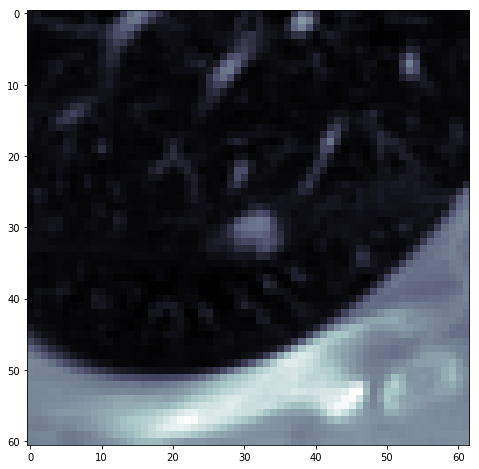

Nodule center scoordinate is in (Z, X, Y) format:  [206 182 101]
Voxel value at nodule center is :  -39 

Patch data in 60x60 mm  :  
 [[-103  -96 -101 ... -888 -890 -895]
 [-105 -108 -105 ... -897 -905 -878]
 [-106 -109  -97 ... -876 -878 -856]
 ...
 [ 181  442  527 ... -776 -789 -791]
 [ 249  494  539 ... -349 -427 -490]
 [ 293  516  528 ...  119  -56 -238]]


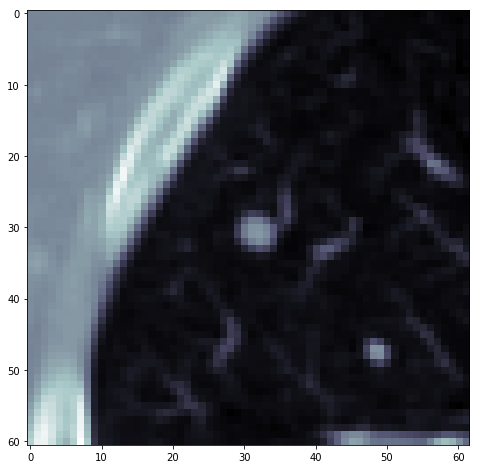

Nodule center scoordinate is in (Z, X, Y) format:  [226 256 249]
Voxel value at nodule center is :  37 

Patch data in 60x60 mm  :  
 [[-594 -630 -676 ... -619 -376 -484]
 [-670 -687 -710 ... -699 -484 -585]
 [-679 -734 -746 ... -869 -809 -781]
 ...
 [  19   25   32 ...   50   53   49]
 [  40   38   43 ...   38   41   50]
 [  51   50   43 ...   50   44   36]]


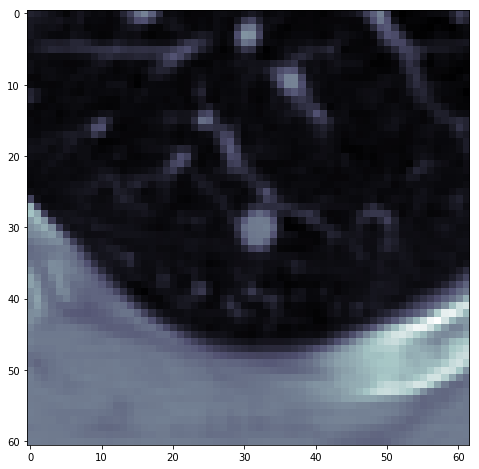

Nodule center scoordinate is in (Z, X, Y) format:  [159 178  69]
Voxel value at nodule center is :  -307 

Patch data in 60x60 mm  :  
 [[ -81  -81 -100 ... -861 -848 -860]
 [ -75  -54  -73 ... -863 -844 -857]
 [ -75  -44  -36 ... -858 -857 -862]
 ...
 [-100 -105  -98 ... -752 -683 -685]
 [ -99 -106 -106 ... -776 -742 -717]
 [ -90 -109 -101 ... -797 -775 -753]]


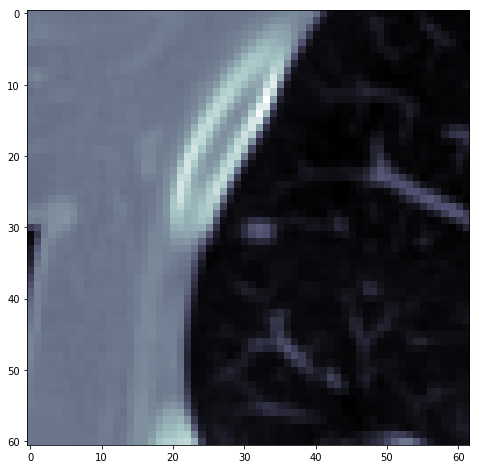

Nodule center scoordinate is in (Z, X, Y) format:  [143 238 180]
Voxel value at nodule center is :  0 

Patch data in 60x60 mm  :  
 [[-858 -842 -789 ...  284  278  289]
 [-817 -804 -781 ...  282  298  285]
 [-782 -812 -824 ...  286  284  263]
 ...
 [-808 -800 -811 ...   81   34    0]
 [-833 -794 -798 ...  150   54   31]
 [-822 -808 -797 ...  179   56   27]]


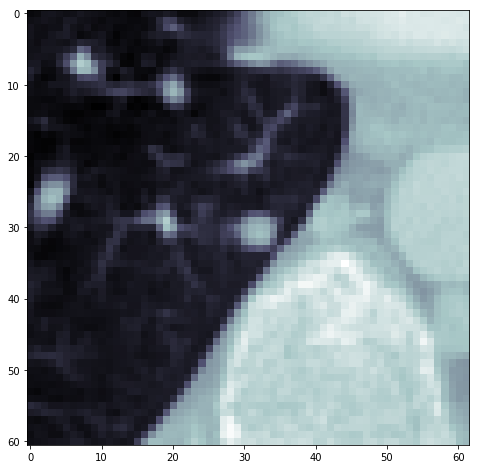

Nodule center scoordinate is in (Z, X, Y) format:  [225 210 278]
Voxel value at nodule center is :  -71 

Patch data in 60x60 mm  :  
 [[-813 -822 -825 ...   55   10  -70]
 [-797 -817 -827 ...   55   45  -42]
 [-793 -833 -825 ...   47   50   -5]
 ...
 [-800 -778 -813 ...  116    7  -52]
 [-800 -787 -802 ...   71   -2  -58]
 [-804 -795 -800 ...   35   -9  -88]]


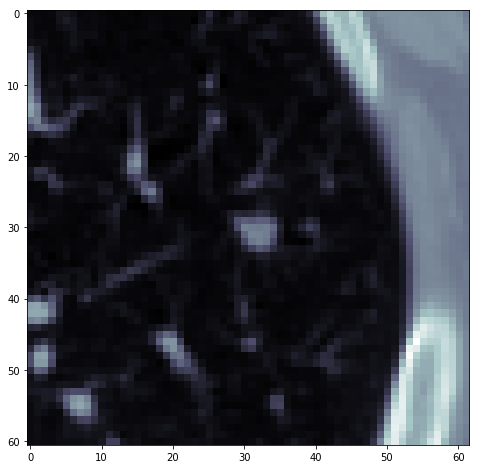

Nodule center scoordinate is in (Z, X, Y) format:  [215 241 267]
Voxel value at nodule center is :  -124 

Patch data in 60x60 mm  :  
 [[-731 -697 -818 ... -834 -825 -815]
 [-673 -691 -828 ... -829 -784 -725]
 [-772 -786 -820 ... -794 -691 -646]
 ...
 [-657 -651 -685 ...   -4   22   36]
 [-676 -639 -605 ...   19   26   34]
 [-622 -655 -648 ...   13   12   14]]


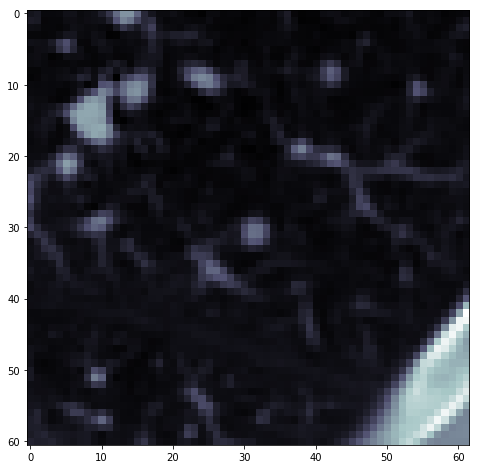

Nodule center scoordinate is in (Z, X, Y) format:  [172 223 306]
Voxel value at nodule center is :  -14 

Patch data in 60x60 mm  :  
 [[-683 -815 -844 ...  -83  -84  -95]
 [-784 -863 -855 ...  -98  -84  -89]
 [-808 -841 -861 ...  -93  -87  -82]
 ...
 [-767 -796 -822 ...  -54   -6   31]
 [-752 -771 -809 ...  -47  -20    0]
 [-791 -800 -776 ...  -66  -42   -9]]


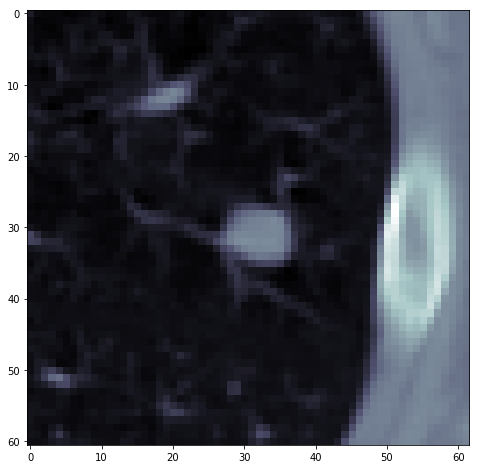

In [19]:
patchCoord_lst = []

for cand in cands[1:]:
    fig,ax = plt.subplots(figsize=(8,8))
    worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
    voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing_Normalized)
    
    patchWidth = 60 # as the maximum size of a Nodule can be upto 30 mm

#     patch = img_np_array_norm[voxelCoord[0], \
#                        voxelCoord[1] - 3 : voxelCoord[1] + 4, \
#                        voxelCoord[2] - 3 : voxelCoord[2] + 4]
    
    patch = img_np_array_norm[voxelCoord[0], \
                       voxelCoord[1] - 30 : voxelCoord[1] + 31, \
                       voxelCoord[2] - 31 : voxelCoord[2] + 31]
    
#    patch = normalizePlanes(patch) ....:need to think on normalizing HU for each Patch 
    patchCoord_lst.append((voxelCoord,patch))

    print ('Nodule center scoordinate is in (Z, X, Y) format:  {}'.format(voxelCoord) );
    print ('Voxel value at nodule center is :  {} \n'.\
           format(img_np_array_norm[voxelCoord[0], voxelCoord[1],voxelCoord[2]]) );
    
    print ('Patch data in 60x60 mm  :  \n {}'.format(patch) );
    plt.imshow(patch, cmap='bone')
    plt.show()    
    
    outputDir = 'patches/'
    fig.savefig(os.path.join(outputDir, 'patch_' + str(voxelCoord[0]) + '_' + str(voxelCoord[1]) +\
                             '_' + str(voxelCoord[2])) )


#### We notice a low resolution of patch images as the size is just 60x60 mm (Voxels)

In [20]:
#Reference